In [1]:
def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (255, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
   
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [2]:
def draw_line(mask, color=(1,0,0), width=3):
    mapimg = (mask == 0).astype(int)

    ver_seg = np.where(mapimg[:,1:] != mapimg[:,:-1])
    hor_seg = np.where(mapimg[1:,:] != mapimg[:-1,:])


    l = []
    for p in zip(*hor_seg):
        l.append((p[1], p[0]+1))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan,np.nan))

    # and the same for vertical segments
    for p in zip(*ver_seg):
        l.append((p[1]+1, p[0]))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan, np.nan))


    segments = np.array(l)

    x0=0
    x1=224
    y0=0
    y1=224

    segments[:,0] = x0 + (x1-x0) * segments[:,0] / mapimg.shape[1]
    segments[:,1] = y0 + (y1-y0) * segments[:,1] / mapimg.shape[0]
    
    plt.plot(segments[:,0], segments[:,1], color=color, linewidth=width)

In [3]:
import torch
from torch.autograd import Variable
from torchvision import models
import cv2
import sys
import numpy as np

from matplotlib import pyplot as plt
#%matplotlib inline

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

def tv_norm(input, tv_beta):
    img = input[0, 0, :]
    row_grad = torch.mean(torch.abs((img[:-1 , :] - img[1 :, :])).pow(tv_beta))
    col_grad = torch.mean(torch.abs((img[: , :-1] - img[: , 1 :])).pow(tv_beta))
    return row_grad + col_grad

def preprocess_image(img):
    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[: , :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))

    if use_cuda:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img).cuda()
    else:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img)

    preprocessed_img_tensor.unsqueeze_(0)
    return Variable(preprocessed_img_tensor, requires_grad = False)

def sv_res(path, content, area_mask = None, do_mask = False):
    plt.ioff()
    fig = plt.figure()
    plt.imshow(np.uint8(255*content))
    if do_mask: 
        draw_line(area_mask, width=4, color=(0,0,0.7))
    fig.savefig(path, bbox_inches='tight')
    
def save(name, mask, img, area_mask = None, do_mask = False, full_mask = False):
    mask = mask.cpu().data.numpy()[0]
    mask_out = mask * (1-area_mask)
    
    mask = np.transpose(mask, (1, 2, 0))
    mask = (mask - np.min(mask)) / np.max(mask)
    mask = 1 - mask
    
    mask_out = np.transpose(mask_out, (1, 2, 0))
    mask_out = (mask_out - np.min(mask_out)) / np.max(mask_out)
    mask_out = 1 - mask_out
    
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap_out = cv2.applyColorMap(np.uint8(255*mask_out), cv2.COLORMAP_JET)
    
    heatmap = np.float32(heatmap) / 255
    heatmap_out = np.float32(heatmap_out) / 255
    
    cam = 1.0*heatmap + np.float32(img)/255
    cam = cam / np.max(cam)
    
    cam_out = 1.0*heatmap_out + np.float32(img)/255
    cam_out = cam_out / np.max(cam_out)
    
    pre_name = './results-seg/' + name + '/' + name
    if do_mask:
        pre_name = pre_name + '-mask'
    if full_mask:
        pre_name = pre_name + '-full'
        
    sv_res(pre_name + "-heatmap.png", heatmap, area_mask, do_mask)
    cv2.imwrite(pre_name + "-mask.png", np.uint8(255*mask))
    sv_res(pre_name + "-cam.png", cam, area_mask, do_mask)
    sv_res(pre_name + "-cam-out.png", cam_out, area_mask, do_mask)

def numpy_to_torch(img, requires_grad = True):
    if len(img.shape) < 3:
        output = np.float32([img])
    else:
        output = np.transpose(img, (2, 0, 1))

    output = torch.from_numpy(output)
    if use_cuda:
        output = output.cuda()

    output.unsqueeze_(0)
    v = Variable(output, requires_grad = requires_grad)
    return v

def load_model():
    model = models.segmentation.deeplabv3_resnet101(pretrained=True)
    model.eval()
    return model

In [4]:
def get_area_mask(do_mask = False, mask = "dog", full_mask = False):
    if (not do_mask): return np.zeros((224, 224), dtype = np.float32)
    if mask == "dog":
        if not full_mask:
            return np.load('./faces/dog-mask.npy')
        return np.load('./full/dog-full.npy')
    
    if mask == "cat":
        if not full_mask:
            return np.load('./faces/cat-mask.npy')
        return np.load('./full/cat-full.npy')
    
    if mask == "person":
        if not full_mask:
            return np.load('./faces/person-mask.npy')
        return np.load('./full/person-full.npy')

## Segmentation

In [7]:
#!wget https://enviragallery.com/wp-content/uploads/2018/10/background.png -O ./segmentation-images/catalone.png
#!wget https://papermilkdesign.com/images/cat-png-dogs-19.png -O ./segmentation-images/dogcat.png
#!wget https://i.ibb.co/BrNP4bc/motobiker.png -O ./segmentation-images/motobiker.png
!wget https://i.ibb.co/TW24DM0/motorbiker2.png -O ./segmentation-images/motobiker2.png

--2019-12-31 15:33:57--  https://i.ibb.co/TW24DM0/motorbiker2.png
S'està resolent i.ibb.co (i.ibb.co)... 51.15.23.171, 51.15.23.163
S'està connectant a i.ibb.co (i.ibb.co)|51.15.23.171|:443... conectat.
HTTP: s'ha enviat la petició, s'està esperant una resposta... 200 OK
Mida: 233460 (228K) [image/png]
S'està desant a: «./segmentation-images/motobiker2.png»

./segmentation-imag 100%[===================>] 227,99K  1,20MB/s    in 0,2s    

2019-12-31 15:33:58 (1,20 MB/s) - s'ha desat «./segmentation-images/motobiker2.png» [233460/233460]



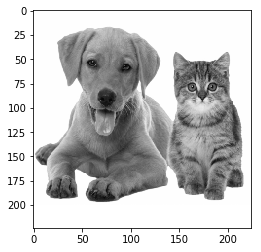

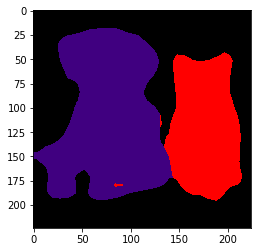

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

import cv2
import numpy as np


def save_greyscale(name):
    img = cv2.imread('./segmentation-images/' + name + '.png')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2 = np.zeros_like(img)
    img2[:,:,0] = gray
    img2[:,:,1] = gray
    img2[:,:,2] = gray

    image_path = './segmentation-images/' + name + 'gray.png'
    cv2.imwrite(image_path, img2)
    img = Image.open(image_path)
    plt.imshow(img) 
    plt.show()


def do_segment(name):
    image_path = './segmentation-images/' + name + 'gray.png'
    
    original_img = cv2.imread(image_path, 1)
    original_img = cv2.resize(original_img, (224, 224))
    img = original_img
    img = np.float32(original_img) / 255

    plt.imshow(img); plt.show()

    img = preprocess_image(img)
    model = load_model()
    res = model(img)['out']
    om = torch.argmax(res.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    
    plt.show()
    
    fig = plt.figure()
    plt.imshow(rgb)
    fig.savefig('./segmentation-images/' + name + '-segmented.png', bbox_inches='tight')
    

#save_greyscale("dogcat")
do_segment("dogcat")

In [10]:
def explain_classification(name, target_class, do_mask = False, full_mask = False):
    learning_rate = 0.1
    max_iterations = 250
    l1_coeff = 0.01
    image_path = "./segmentation-images/" + name + "gray.png"

    model = load_model()
    original_img = cv2.imread(image_path, 1)
    original_img = cv2.resize(original_img, (224, 224))
    img = np.float32(original_img) / 255


    blurred_img_init = np.float32(cv2.medianBlur(original_img, 21))/255

    # Convert to torch variables
    img = preprocess_image(img)
    blurred_img = preprocess_image(blurred_img_init)


    mask_init = np.ones((28, 28), dtype = np.float32)
    mask = numpy_to_torch(mask_init)

    upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224)).cuda()

    optimizer = torch.optim.Adam([mask], lr=learning_rate)

    # Auxiliar zeros tensor
    zero_t = np.zeros((224, 224), dtype = np.float32)
    zero_t = numpy_to_torch(zero_t, requires_grad = False)

    # Initial segmentation
    target = model(img)['out']

    seg = torch.argmax(target.squeeze(), dim=0).detach().cpu().numpy()
    area_mask = (seg == target_class).astype(int)
    R = numpy_to_torch(area_mask, requires_grad = False)

    fcx = target.squeeze()[target_class]
    l1r = torch.mean(torch.abs(1 - R))
    
    print("-------------------")
    print("IMAGE:" + name)
    print("-------------------")
    print("Target class: ")
    print(target_class)
    print("Optimizing.. ")
    print("Iterations:")

    for i in range(max_iterations):
        if i%25 == 0: 
            print(i)

        def_mask = upsample(mask)
        upsampled_mask = def_mask
        upsampled_mask = upsampled_mask.expand(1, 3, upsampled_mask.size(2),  upsampled_mask.size(3))

        # Use the mask to perturbated the input image.
        perturbated_input = img.mul(upsampled_mask) + blurred_img.mul(1-upsampled_mask)


        fcxp = model(perturbated_input)['out'].squeeze()[target_class]
        subs = fcx - fcxp
        maxs = torch.max(subs,zero_t)
        mul = torch.mul(R, maxs)
        l1mul = torch.mean(torch.abs(mul))

        l1m = l1_coeff*torch.mean(torch.abs(mask))

        loss = l1m + (l1mul / l1r)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        mask.data.clamp_(0, 1)

    upsampled_mask = upsample(def_mask)
    save(name, upsampled_mask, original_img, area_mask, True, False)

    print("--------------END--------------")

-------------------
IMAGE:dogcat
-------------------
Target class: 
8
Optimizing.. 
Iterations:
0
25
50
75
100
125
150
175
200
225
--------------END--------------
-------------------
IMAGE:catalone
-------------------
Target class: 
8
Optimizing.. 
Iterations:
0
25
50
75
100
125
150
175
200
225
--------------END--------------
-------------------
IMAGE:motobiker
-------------------
Target class: 
14
Optimizing.. 
Iterations:
0
25
50
75
100
125
150
175
200
225
--------------END--------------
-------------------
IMAGE:motobiker2
-------------------
Target class: 
14
Optimizing.. 
Iterations:
0
25
50
75
100
125
150
175
200
225
--------------END--------------


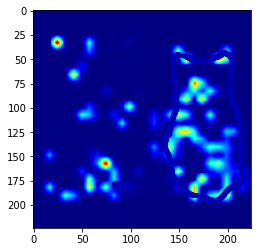

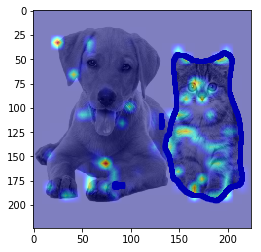

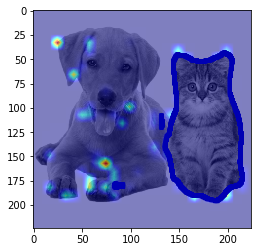

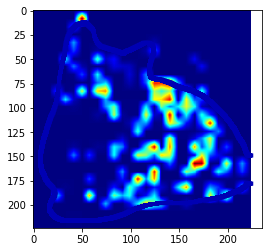

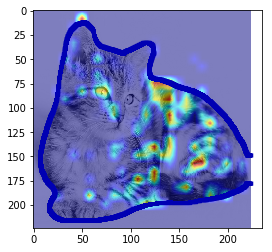

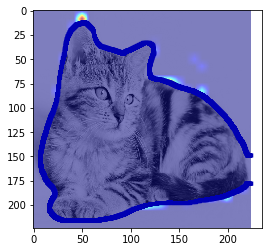

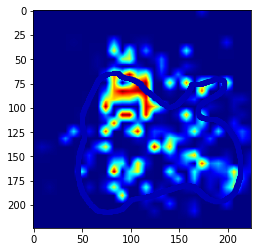

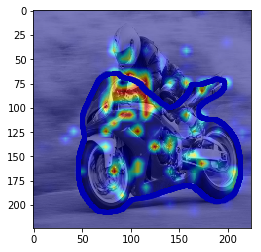

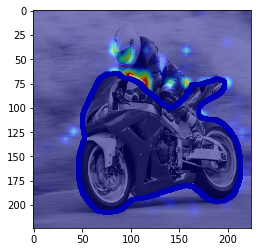

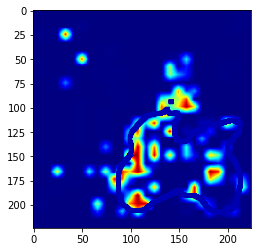

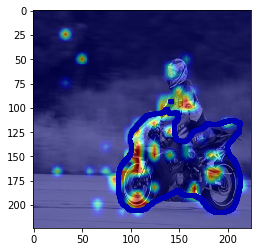

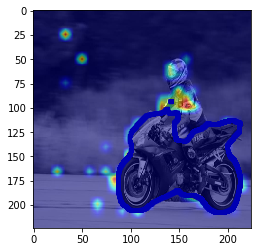

In [11]:
#Target classes:
# 8 cat
# 14 motorbike
import os
img_names = ["dogcat", "catalone", "motobiker", "motobiker2"]
target_classes = [8,8,14,14]

for i, name in enumerate(img_names):
    try:
        os.mkdir("results-seg/" + name)
    except:
        pass
    
    target_class = target_classes[i]
    explain_classification(name, target_class, do_mask = False)